# Analyzing networks model

In [1]:
### import libraries

import pandas as pd
import igraph as ig
import numpy as np
import matplotlib.pyplot as plt

In [2]:
### User and resource attributes for each dataset

DS_ID = "IoT" # Availables => user_attributes.keys()
# OUT_FILE = open(DS_ID+".output", "w") # File to save the outputs

USER_ATTRS = {"IoT": ["role", "age", "health", "uname"],
              "AMZ": ["MGR_ID","ROLE_ROLLUP_1","ROLE_ROLLUP_2","ROLE_DEPTNAME","ROLE_TITLE","ROLE_FAMILY_DESC","ROLE_FAMILY","ROLE_CODE"],
              "HC": ["position", "uward", "specialties", "teams", "agentfor", "uname"],
              "UN": ["position","departmentu","crsTaken","crsTaught","isChair", "uname"],
              "PM": ["adminroles","projects","departmentu","projectsled","expertiseu","isemployee","task","uname"]}

RES_ATTRS = {"IoT": ["area", "mode", "temperature", "lockstatus", "rname"],
             "AMZ":["RID"],
             "HC": ["type", "author", "patient", "topics", "tratingTeam", "rward", "rname"],
             "UN": ["type","student","departmentr","csr", "rname"],
             "PM": ["type","project","department","expertise","proprietary", "rname"]}

EDG_ATTRS = {"IoT": ["uname", "rname", "location", "timeday", "op", "ACTION"],
             "AMZ": ["uname", "rname"],
             "HC": ["uname", "rname"],
             "UN":["uname", "rname"],
             "PM":["uname", "rname"]}

def get_probability_distribution(n, sample_size, probability_parameters, type="normal",):
    """ Get the probability distribution for n elementsin sample size."""
    distri = None

    if type==None:
        return None

    if type=="normal":
        distri = np.random.normal(probability_parameters["mu"], 
                                  probability_parameters["sigma"], 
                                  size=sample_size)        

    if type=="pareto":        
        distri = (np.random.pareto(probability_parameters["alpha"], sample_size) + 1) * probability_parameters["mu"]        

    if type=="poisson":
        distri = np.random.poisson(probability_parameters["lam"],
                                   size=sample_size)        

    if type=="exponential":
        new_scale = 1 / probability_parameters["lam"]
        # Generate values for the x-axis
        x = np.linspace(0, n, sample_size)
        # Calculate the PDF with the new scale parameter
        distri = expon.pdf(x, scale=new_scale)

    if type=="uniform":
        distri = np.random.uniform(probability_parameters["low"],
                                   probability_parameters["high"],
                                   size=sample_size)

    count, _, _ = plt.hist(distri, n)  
    return count/sample_size

def get_sample_by_distribution(access_log, sample_size, prob_distri, class_name):
    """ Sampling a dataframe based on a given distribution. """
    new_sample = pd.DataFrame() # Store all access requests
    for i in prob_distri.iloc:
        temp = access_log[access_log[class_name]==i[0]]
        n_samples = int(i[1]*sample_size)        
        temp = temp.sample(n=n_samples, replace=True)
        new_sample = pd.concat([new_sample, temp])

    return new_sample

In [45]:
str_dataset = "UN"
type_al = "Ps"
filename = "../data/"+str_dataset+"/"+str_dataset+"-"+type_al+".csv"

acc_log = pd.read_csv(filename)

# Remove first column (is the old index)
if not str_dataset in ["AMZ", "ML"]:
    acc_log = acc_log[acc_log.columns[1:]]

# Change the uname string values to int values
if not str_dataset in ["AMZ","ML", "UN", "PM", "IoT"]:
    acc_log = acc_log.replace(acc_log.uname.unique(), range(len(acc_log.uname.unique())))

# Change the resource id
if not str_dataset in ["UN", "PM", "AMZ", "ML", "IoT"]:
    acc_log["rname"] = acc_log["rname"] + max(acc_log.uname.unique()) + 1

print("Done!")
print(acc_log.head(5)) # Show the first five rows
print(len(acc_log))

# Delete some variables
del filename

Done!
   uname position departmentu crsTaken crsTaught  isChair         rname  \
0     29  student          cs    cs602     ee601        0  application1   
1     45  student          cs    ee602     cs602        0  application1   
2     50  student          ee    cs101     cs601        0  application1   
3     43  student          cs    ee602     cs101        0  application1   
4     22  student          cs    cs601     ee101        0  application1   

          type student departmentr   csr  ACTION  
0  application       0        none  none       0  
1  application       0        none  none       0  
2  application       0        none  none       0  
3  application       0        none  none       0  
4  application       0        none  none       0  
27953


In [46]:
### Generate biparite graph
if str_dataset == "ML":
    acc_log_sub = acc_log
else:
    acc_log_sub = acc_log[acc_log.ACTION == 1]
acc_log_freq = acc_log_sub.value_counts(["uname", "rname"], normalize=True)
test = pd.DataFrame(list(acc_log_freq.keys()), columns=["uname", "rname"])
print("|L+|", len(acc_log_sub))
print("Elementos repetidos", len(acc_log_sub) - len(test))
print("Elementos únicos",len(test))
print()
test["weight"] = acc_log_freq.values
print("MAX FREQ", max(test["weight"]))
print("MIN FREQ", min(test["weight"]))
print()
# Iteration over tuples in the dataframe
tuple_list = test.itertuples(index=False)

# Using the TupleList method to build the network
bip_network = ig.Graph.TupleList(tuple_list, directed=False,
                                 edge_attrs=test.columns[2:].tolist())

### Add user attributes

# Add type of node:     0=User      1=Resource
user_nodes = bip_network.vs.select(name_in=acc_log.uname.unique())
resource_nodes = bip_network.vs.select(name_in=acc_log.rname.unique())
user_nodes["type"] = 0
resource_nodes["type"] = 1

# Remove objecto to free memory
#del user_nodes, resource_nodes

print(bip_network.summary())
print(len(user_nodes), len(resource_nodes))

# Check if it is a bipartite network
if bip_network.is_bipartite():
    print("It is bipartite!")
else:
    print("The network is not bipartite.")

|L+| 3455
Elementos repetidos 3402
Elementos únicos 53

MAX FREQ 0.08596237337192475
MIN FREQ 0.0002894356005788712

IGRAPH UNWT 37 53 -- 
+ attr: name (v), type (v), weight (e)
25 12
It is bipartite!


c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\igraph\__init__.py:4541: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  "in": lambda a, b: a in b,


In [47]:
for i in bip_network.vs():
    i["name"] = str(i["name"])

In [48]:
graph = bip_network

# Inicializar el atributo "ranking" de los nodos
graph.vs["ranking"] = 0.0

# Calcular la suma de los pesos de las aristas adyacentes para cada nodo
#for node in graph.vs:
for node in user_nodes:
    neighbors = graph.neighbors(node.index)
    total_weight = sum(graph.es[edge]["weight"] for edge in graph.incident(node.index))
    node["ranking"] = total_weight

for node in resource_nodes:
    neighbors = graph.neighbors(node.index)
    total_weight = sum(graph.es[edge]["weight"] for edge in graph.incident(node.index))
    node["ranking"] = total_weight
print(graph.vs["ranking"][:5])

bip_network.write("binet-"+str_dataset+"-"+type_al+".gml")

[0.10390738060781476, 0.2714905933429812, 0.08017366136034733, 0.2451519536903039, 0.08914616497829234]


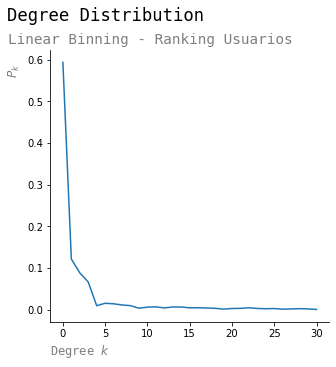

In [15]:
fig, ax = plt.subplots(figsize=(5, 5))
#ax.loglog()
ax.spines[['right', 'top']].set_visible(False)
ax.plot(range(len(user_nodes)), user_nodes["ranking"])
# ax.plot(range(max_degree), test, ls="--")
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning - Ranking Usuarios", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()

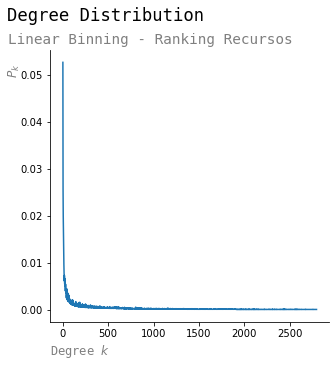

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
#ax.loglog()
ax.spines[['right', 'top']].set_visible(False)
ax.plot(range(len(resource_nodes)), resource_nodes["ranking"])
# ax.plot(range(max_degree), test, ls="--")
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning - Ranking Recursos", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()

In [117]:
# Imprimir información básica del grafo
print("Información del Grafo:")
print(graph.summary())

# Obtener y mostrar métricas del grafo
print("\nMétricas del Grafo:")
print(f"Número de nodos: {graph.vcount()}")
print(f"Número de aristas: {graph.ecount()}")
print(f"Grado promedio: {ig.mean(graph.degree())}")
print("Peso de Grado promedio: ", ig.mean(graph.es["weight"]))
print("Degree distribution")
print(f"Densidad: {graph.density()}")
print(f"Diámetro del grafo: {graph.diameter()}")
print(f"Average path lenght: {graph.average_path_length()}")
print(f"Componentes conectados: {len(graph.components().subgraphs())}")
#print(f"Coeficiente de clustering: {graph.transitivity_undirected()}")
print(f"Coeficiente de asortatividad: {graph.assortativity_degree()}")

Información del Grafo:
IGRAPH UNWT 184 5007 -- 
+ attr: name (v), ranking (v), type (v), weight (e)

Métricas del Grafo:
Número de nodos: 184
Número de aristas: 5007
Grado promedio: 54.42391304347828
Peso de Grado promedio:  0.00019972039145196683
Degree distribution
Densidad: 0.29739843193157517
Diámetro del grafo: 4
Average path lenght: 1.928783559040152
Componentes conectados: 1
Coeficiente de asortatividad: -0.2904896056818339


In [225]:
max_degree = max(graph.degree())

degree_list = np.zeros(max_degree, dtype=int)

for node in graph.vs():
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / graph.vcount()
result = ig.power_law_fit(graph.degree())
test = np.arange(max_degree)
test = test ** -result.alpha

c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()


In [1]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.loglog()
ax.spines[['right', 'top']].set_visible(False)
ax.plot(range(max_degree), degree_list, "o", ls='None')
# ax.plot(range(max_degree), test, ls="--")
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning - "+str_dataset+"."+type_al, loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()

NameError: name 'plt' is not defined

# Ruido

In [101]:
from sklearn.model_selection import StratifiedShuffleSplit

In [106]:
### Noisy Generation

def get_noisy_al(access_log, fraction, random_state=None, previous_al=None):
    """ Compute the noisy access log (NAL) version. """
    acc_log = access_log
    acc_log["flag"] = 0
    
    if isinstance(previous_al, pd.DataFrame): # idk
        acc_log = previous_al

    noysi_al = None
    
    if random_state != None:
        noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                    train_size = 1-fraction,
                                                    random_state = random_state)        
    else:
        noisy_separation = StratifiedShuffleSplit(n_splits = 1,
                                                    train_size = 1-fraction)        
    
    noisy_acc_log_selection = noisy_separation.split(acc_log, acc_log.ACTION)
                    
    noisy_acc_req = None
    normal_acc_req = None
    for noisy_idx, normal_idx, in noisy_acc_log_selection:
        noisy_acc_req = acc_log.iloc[noisy_idx]
        normal_acc_req = acc_log.iloc[normal_idx]

    # Change the resolution in the noisy_selection dataset
    noisy_acc_req["ACTION"] = np.where(noisy_acc_req["ACTION"] == 0, 1, 0)
    noisy_acc_req["flag"] = 1

    noysi_al = pd.concat([noisy_acc_req, normal_acc_req])

    return noysi_al

def eliminar_repetidos_con_mayor_peso(df):
    # Ordenar el DataFrame por la columna "weight" en orden descendente
    df_ordenado = df.sort_values(by='weight', ascending=False)
    
    # Mantener la primera aparición de cada combinación única de "name" y "resource"
    df_sin_repetidos = df_ordenado.drop_duplicates(subset=['uname', 'rname'], keep='first')
    
    return df_sin_repetidos

In [136]:
import pandas as pd
import numpy as np


# Definir la cantidad de registros en el DataFrame
num_registros = 1000

# Crear un DataFrame con una columna "ACTION"
df = pd.DataFrame({'ACTION': [1] * int(0.85 * num_registros) + [0] * int(0.15 * num_registros)})

# Mostrar el DataFrame resultante
print(df.value_counts())

ACTION
1         850
0         150
dtype: int64


In [137]:
def cambiar_valores_preservando_proporcion(df, columna_a_cambiar, fraccion_a_cambiar):
    # Verifica que la columna especificada exista en el DataFrame
    if columna_a_cambiar not in df.columns:
        print(f"La columna '{columna_a_cambiar}' no existe en el DataFrame.")
        return None

    # Verifica que la fracción esté en el rango [0, 1]
    if fraccion_a_cambiar < 0 or fraccion_a_cambiar > 1:
        print("La fracción a cambiar debe estar en el rango [0, 1].")
        return None

    # Calcula la cantidad de filas a cambiar basándose en la fracción proporcionada
    cantidad_filas_cambiar = int(fraccion_a_cambiar * len(df))
    print(cantidad_filas_cambiar)

    # Filtra el DataFrame por la clase especificada
    df_clase_permit = df[df[columna_a_cambiar] == 1]    
    df_clase_deny = df[df[columna_a_cambiar] == 0]

    # Verifica que haya suficientes filas para cambiar en ambas clases
    if cantidad_filas_cambiar > min(len(df_clase_permit), len(df_clase_deny)):
        print("No hay suficientes filas en una o ambas clases para cambiar.")
        return None

    # Selecciona aleatoriamente las filas a cambiar en cada clase
    filas_cambiar_permit = np.random.choice(df_clase_permit.index, size=int(cantidad_filas_cambiar / 2), replace=False)
    filas_cambiar_deny = np.random.choice(df_clase_deny.index, size=int(cantidad_filas_cambiar / 2), replace=False)

    # Cambia los valores de las filas seleccionadas
    df.loc[filas_cambiar_permit, columna_a_cambiar] = 0
    df.loc[filas_cambiar_deny, columna_a_cambiar] = 1

    return df

# Llama a la función para cambiar los valores preservando la proporción
df_modificado = cambiar_valores_preservando_proporcion(df, "ACTION", 0.15)
print(df_modificado.info())
print(df_modificado.value_counts())

150
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ACTION  1000 non-null   int64
dtypes: int64(1)
memory usage: 7.9 KB
None
ACTION
1         850
0         150
dtype: int64


In [104]:
print("DENY=", len(acc_log[acc_log.ACTION == 0]), " \t PERMIT=",
      len(acc_log[acc_log.ACTION == 1]))

noisy_al = get_noisy_al(acc_log, fraction=0.1)

print("DENY=", len(noisy_al[noisy_al.ACTION == 0]), " \t PERMIT=",
      len(noisy_al[noisy_al.ACTION == 1]))


DENY= 123161  	 PERMIT= 29938


c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
c:\Users\danie\anaconda3\envs\tesis_env\lib\site-packages\ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


DENY= 113840  	 PERMIT= 39259


In [138]:
### Generate biparite graph
acc_log_sub = noisy_al[noisy_al.ACTION == 1]
acc_log_freq = acc_log_sub.value_counts(["uname", "rname"], normalize=True)
test = pd.DataFrame(list(acc_log_freq.keys()), columns=["uname", "rname"])
test["weight"] = acc_log_freq.values
azucar = eliminar_repetidos_con_mayor_peso(test)
azucar

NameError: name 'noisy_al' is not defined

In [126]:
import networkx as nx
def get_edge_weight(i_node, j_node):
    """
    Compute the weight of an edge between i and j nodes.

    Args:
        i_node (networkX node): i node.
        j_node (networkX node): j node.

    Returns:
        weight (float): The weight between nodes.

    Raises:
        TypeError: if there are not an intersection
    """
    neighs_i = set(i_node.neighbors())  # Set of neighbors of i
    neighs_j = set(j_node.neighbors())  # Set of neighbors of j

    # Calculate intersection between two previous sets
    insersection_neighbors = neighs_i.intersection(neighs_j)

    weight = (len(insersection_neighbors)*len(insersection_neighbors)
              ) / (len(neighs_i)*len(neighs_j))

    return weight

def bipartite_projection(biparte_network, node_type=0):
    """
    Generate a monopartite network from bipartite network.

    Parameters:
        bipartite_network (igraph Graph): The bipartie network.
        node_type (int): The set of nodes of the monopartite network.

    Returns:
        Graph (iGraph): The monopartite (projected) network.

    Raises:
        Some
    """

    # Check if the bipartite network is a bipartite network:
    if not biparte_network.is_bipartite():
        raise TypeError("The ARBN is not bipartite")

    # networkX object (more easy to buil)
    g = nx.Graph()

    # All opposite node set
    opposite_nodes = biparte_network.vs.select(type=1)

    # Check for every node the same type
    for X_node in opposite_nodes:
        # Select all neighbors of the X_node
        neighbordhood = X_node.neighbors()

        for Y_node_i in neighbordhood:
            for Y_node_j in neighbordhood:
                # Ceck if both nodes are the same
                if Y_node_i['name'] != Y_node_j['name']:
                    # If there is no an edge generate
                    if not g.has_edge(Y_node_i['name'], Y_node_j['name']):
                        weight_ = get_edge_weight(Y_node_i, Y_node_j)
                        # print("Peso: ", Y_node_i['name'], "-", Y_node_j['name'], " => ", weight_)
                        g.add_edge(Y_node_i["name"], Y_node_j["name"],
                                   weight=weight_)

    # Convert from networkX graph to igraph graph
    g = ig.Graph.from_networkx(g)
    g.vs["name"] = g.vs["_nx_name"]
    del g.vs["_nx_name"]

    for u_nodes in g.vs:
        rsrcs = biparte_network.vs.find(name=u_nodes["name"]).neighbors()
        rsrcs = [r_node["name"] for r_node in rsrcs]
        u_nodes["rsrcs"] = rsrcs

    print("User Network builded!")
    print(g.summary())
    return g

In [227]:
proj = bipartite_projection(bip_network)
max_degree = max(proj.degree())
degree_list = np.zeros(max_degree, dtype=int)

for node in proj.vs():
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / proj.vcount()

User Network builded!
IGRAPH UNW- 105 804 -- 
+ attr: name (v), rsrcs (v), weight (e)


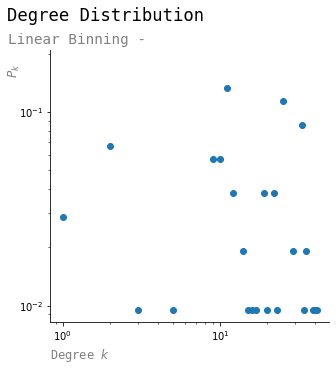

In [228]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.loglog()
ax.spines[['right', 'top']].set_visible(False)
ax.plot(range(max_degree), degree_list, "o", ls='None')
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning - ", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()

User Network builded!
IGRAPH UNW- 105 804 -- 
+ attr: name (v), rsrcs (v), weight (e)


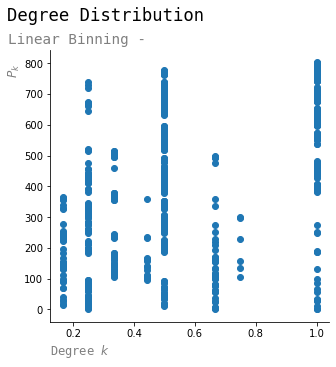

In [229]:
proj = bipartite_projection(bip_network)

fig, ax = plt.subplots(figsize=(5, 5))
#ax.loglog()
ax.spines[['right', 'top']].set_visible(False)
ax.plot( proj.es["weight"],range(len(proj.es)), "o", ls='None')
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning - ", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()

In [202]:
def get_edge_weight_2(i_node, j_node):
    """
    Compute the weight of an edge between i and j nodes.

    Args:
        i_node (networkX node): i node.
        j_node (networkX node): j node.

    Returns:
        weight (float): The weight between nodes.

    Raises:
        TypeError: if there are not an intersection
    """
    neighs_i = set(i_node.neighbors())  # Set of neighbors of i
    neighs_j = set(j_node.neighbors())  # Set of neighbors of j

    # Calculate intersection between two previous sets
    insersection_neighbors = neighs_i.intersection(neighs_j)

    for node in insersection_neighbors:        
        total_weight = sum(bip_network.es[edge]["weight"] for edge in bip_network.incident(node.index))
    
    for nodo in i_node.neighbors():
        i_rank = sum(bip_network.es[edge]["weight"] for edge in bip_network.incident(nodo.index))

    for nodo in j_node.neighbors():
        j_rank = sum(bip_network.es[edge]["weight"] for edge in bip_network.incident(nodo.index))

    weight = (total_weight*total_weight) / (i_rank*j_rank)

    return weight

def bipartite_projection_2(biparte_network, node_type=0):
    """
    Generate a monopartite network from bipartite network.

    Parameters:
        bipartite_network (igraph Graph): The bipartie network.
        node_type (int): The set of nodes of the monopartite network.

    Returns:
        Graph (iGraph): The monopartite (projected) network.

    Raises:
        Some
    """

    # Check if the bipartite network is a bipartite network:
    if not biparte_network.is_bipartite():
        raise TypeError("The ARBN is not bipartite")

    # networkX object (more easy to buil)
    g = nx.Graph()

    # All opposite node set
    opposite_nodes = biparte_network.vs.select(type=1)

    # Check for every node the same type
    for X_node in opposite_nodes:
        # Select all neighbors of the X_node
        neighbordhood = X_node.neighbors()

        for Y_node_i in neighbordhood:
            for Y_node_j in neighbordhood:
                # Ceck if both nodes are the same
                if Y_node_i['name'] != Y_node_j['name']:
                    # If there is no an edge generate
                    if not g.has_edge(Y_node_i['name'], Y_node_j['name']):
                        weight_ = get_edge_weight_2(Y_node_i, Y_node_j)
                        # print("Peso: ", Y_node_i['name'], "-", Y_node_j['name'], " => ", weight_)
                        g.add_edge(Y_node_i["name"], Y_node_j["name"],
                                   weight=weight_)

    # Convert from networkX graph to igraph graph
    g = ig.Graph.from_networkx(g)
    g.vs["name"] = g.vs["_nx_name"]
    del g.vs["_nx_name"]

    for u_nodes in g.vs:
        rsrcs = biparte_network.vs.find(name=u_nodes["name"]).neighbors()
        rsrcs = [r_node["name"] for r_node in rsrcs]
        u_nodes["rsrcs"] = rsrcs

    print("User Network builded!")
    print(g.summary())
    return g

In [159]:
a = bip_network.vs[2]
b = bip_network.vs[20]
a, b

(igraph.Vertex(<igraph.Graph object at 0x0000014EAA70F5E8>, 2, {'name': 2532, 'type': 1, 'ranking': 0.026822099004609527}),
 igraph.Vertex(<igraph.Graph object at 0x0000014EAA70F5E8>, 20, {'name': 2523, 'type': 1, 'ranking': 0.005611597301088917}))

In [184]:
get_edge_weight(a, b)

0.5

In [185]:
get_edge_weight_2(a, b)

1.0

User Network builded!
IGRAPH UNW- 105 804 -- 
+ attr: name (v), rsrcs (v), weight (e)


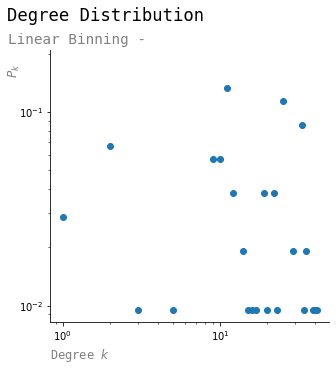

In [230]:
proj = bipartite_projection_2(bip_network)
max_degree = max(proj.degree())
degree_list = np.zeros(max_degree, dtype=int)

for node in proj.vs():
    degree_list[node.degree()-1] = (degree_list[node.degree()-1] + 1)

degree_list = degree_list / proj.vcount()

fig, ax = plt.subplots(figsize=(5, 5))
ax.loglog()
ax.spines[['right', 'top']].set_visible(False)
ax.plot(range(max_degree), degree_list, "o", ls='None')
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning - ", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()

User Network builded!
IGRAPH UNW- 105 804 -- 
+ attr: name (v), rsrcs (v), weight (e)


AttributeError: 'YAxis' object has no attribute 'log'

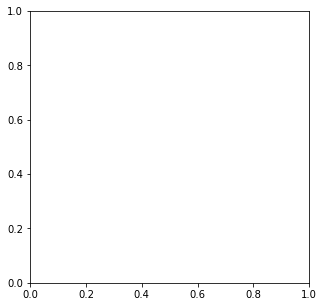

In [234]:
proj = bipartite_projection_2(bip_network)

asd = np.array(proj.es["weight"])/max(proj.es["weight"])

fig, ax = plt.subplots(figsize=(5, 5))
ax.yaxis("")
ax.spines[['right', 'top']].set_visible(False)
#ax.plot(range(len(proj.es)), asd, "o", ls='None')
ax.plot(asd,range(len(proj.es)), "o", ls='None')
ax.set_xlabel('Degree $k$', loc="left", size="large", family='monospace', alpha=0.5, parse_math=True)
ax.set_ylabel('$P_k$', loc="top", size="large", family='monospace',  alpha=0.5,
               parse_math=True)
ax.yaxis.set_label_coords(-0.1,0.95)
ax.set_title("Linear Binning - ", loc='left', size="x-large", family='monospace', x=-0.15, y=1, alpha=0.5)
plt.suptitle("Degree Distribution", size="xx-large", family='monospace', x=0.28, y=1)
plt.show()